In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from helper_functions import plot_loss_curves
import os
from datetime import datetime

2024-03-01 08:45:10.681405: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 08:45:10.704651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 08:45:10.704672: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 08:45:10.704687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 08:45:10.708927: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("./data/data_multiclass_10/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in './data/data_multiclass_10/'.
There are 10 directories and 0 images in './data/data_multiclass_10/test'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/chicken_curry'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/chicken_wings'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/fried_rice'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/grilled_salmon'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/hamburger'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/ice_cream'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/pizza'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/ramen'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/steak'.
There are 0 directories and 250 images in './data/data_multiclass_10/test/sushi

In [4]:
# Setup data inputs
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "./data/data_multiclass_10/train/"
test_dir = "./data/data_multiclass_10/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Found 750 images belonging to 10 classes.


Found 2500 images belonging to 10 classes.


In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [6]:
# Resnet 50 V2 feature vector
resnet_url ="https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"
#resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url ="https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"
#efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [7]:
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    keras.layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

## Build model with resnet

In [8]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

resnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data, validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

2024-02-29 06:12:05.880213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 06:12:05.883095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 06:12:05.883190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240229-061206
Epoch 1/5


2024-02-29 06:12:09.543665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-02-29 06:12:10.250383: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f284b1e2280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-29 06:12:10.250399: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-29 06:12:10.253687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-29 06:12:10.314047: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


24/24 [==============================] - 8s 196ms/step - loss: 1.9745 - accuracy: 0.3747 - val_loss: 1.3147 - val_accuracy: 0.5820
Epoch 2/5
24/24 [==============================] - 4s 171ms/step - loss: 0.9330 - accuracy: 0.7160 - val_loss: 0.8977 - val_accuracy: 0.7132
Epoch 3/5
24/24 [==============================] - 4s 169ms/step - loss: 0.6224 - accuracy: 0.8427 - val_loss: 0.7758 - val_accuracy: 0.7480
Epoch 4/5
24/24 [==============================] - 4s 170ms/step - loss: 0.4773 - accuracy: 0.8773 - val_loss: 0.7223 - val_accuracy: 0.7616
Epoch 5/5
24/24 [==============================] - 4s 168ms/step - loss: 0.3800 - accuracy: 0.9133 - val_loss: 0.6879 - val_accuracy: 0.7808


In [7]:
plot_loss_curves(resnet_history)

NameError: name 'resnet_history' is not defined

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


## Build model with efficientnet

In [11]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, epochs=5, steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data, validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240229-061253
Epoch 1/5
24/24 [==============================] - 9s 194ms/step - loss: 1.9246 - accuracy: 0.3987 - val_loss: 1.3771 - val_accuracy: 0.7032
Epoch 2/5
24/24 [==============================] - 4s 172ms/step - loss: 1.0956 - accuracy: 0.7840 - val_loss: 0.8943 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 4s 173ms/step - loss: 0.7715 - accuracy: 0.8387 - val_loss: 0.7122 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 4s 173ms/step - loss: 0.6142 - accuracy: 0.8720 - val_loss: 0.6199 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 4s 170ms/step - loss: 0.5183 - accuracy: 0.8853 - val_loss: 0.5651 - val_accuracy: 0.8612


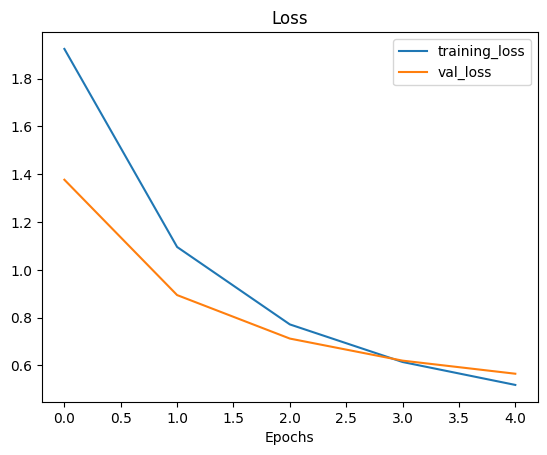

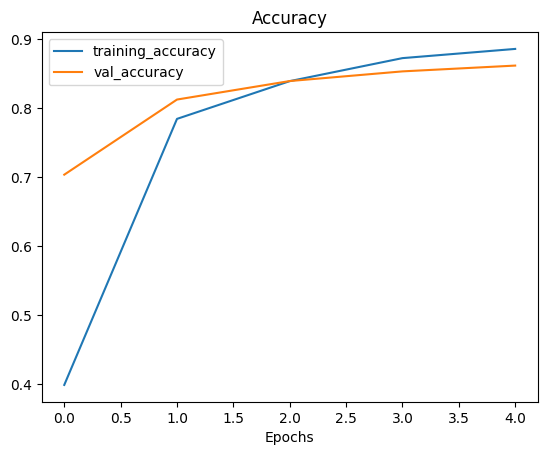

In [12]:
plot_loss_curves(efficientnet_history)

In [13]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


## Comparing models using TensorBoard


In [23]:
# # Upload TensorBoard dev records
# %load_ext tensorboard
# %tensorboard --logdir ./tensorflow_hub/